In [1]:
# Load data into jupyter
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import savefig

def load_csv_file(filename, skiprows = 0):
  return np.loadtxt(open(filename, "rb"), delimiter=",", skiprows = skiprows)

def plot_configuration(config):
  """
  Scatter-plot the 2D array and return the figure;
  :param config: a n x 2 tensor/ndarray 
  """
  figure = plt.figure(figsize = (5,5))
  plt.scatter(config[:,0], config[:,1])
  plt.show()
  return figure

In [2]:
from os import listdir
from os.path import isfile, join

num_joints = 7
limit = 10000000  # set limit on number of points in the configuration
path = "../data/input/right_joint_states"
file_name = ''

files = [f for f in listdir(path) if isfile(join(path, f))]
for f in files:
    
    joints = int(f.split('_')[1])
    num_samples = int(f.split('_')[2])
    if joints == num_joints and num_samples < limit:
        file_name = join(path, f)
        break
print("Loading data from file: %s" % (file_name,))

Loading data from file: ../data/input/right_joint_states/right_7_3556224_1548650769.0.csv


In [3]:
import math

"""
Load and preprocess data; 
"""

def normalize_data(X, limits):
    """
    Normalize the revolute joint data from joints limits to [0, 1]
    X: Data before normalization n x d array
    limits: joint limits for the revolute joints, a 2 x d array
    """
    X = X - limits[0, :]
    x_range = limits[1, :] - limits[0, :]
    return X / x_range

def recover_data(normalized_X, limits):
    """
    Recover the normalized X based on joint limits.
    normalized_X: the normalized data points;
    limits: the joint limits
    """
    x_range = limits[1, :] - limits[0, :]
    X = normalized_X * x_range
    return X + limits[0, :]

In [4]:
def test_normalize_data():
    X = np.array([
        [-1.7016, -2.147, -3.0541],
        [1.7016, 1.047, 3.0541],
        [0.087478421724874522,0.49571075835981837, -0.50648066618520682]
    ])
    limits = np.array([
        [-1.7016,-2.147,-3.0541],
        [1.7016, 1.047, 3.0541]
    ])
    print(normalize_data(X, limits))    
    
def test_recover_data():
    X = np.array([
        [0, 0, 0],
        [1, 1, 1],
        [0.5,0.5, 0.5]
    ])
    limits = np.array([
        [-1.7016,-2.147,-3.0541],
        [1.7016, 1.047, 3.0541]
    ])
    print(recover_data(X, limits))

test_normalize_data()
test_recover_data()

[[0.         0.         0.        ]
 [1.         1.         1.        ]
 [0.52570475 0.82739848 0.41708185]]
[[-1.7016 -2.147  -3.0541]
 [ 1.7016  1.047   3.0541]
 [ 0.     -0.55    0.    ]]


In [5]:
JOINT_NAMES = ['s0','s1','e0','e1','w0','w1','w2']
JOINT_LIMITS = {
    's0': [-1.7016, 1.7016],
    's1': [-2.147, 1.047],
    'e0': [-3.0541, 3.0541],
    'e1': [-0.05, 2.618],
    'w0': [-3.059, 3.059],
    'w1': [-1.5707, 2.094],
    'w2': [-3.059, 3.059]
}

collisionKey = 'inCollision' 
HEADERS = ['right_' + joint_name for joint_name in JOINT_NAMES]

selected_joints = JOINT_NAMES[0:num_joints]
joint_limits = [JOINT_LIMITS[joint] for joint in selected_joints]
joint_limits = np.array(joint_limits).T
headers = ['right_' + joint_name for joint_name in selected_joints]

headers_w_collision = headers.copy()
headers_w_collision.append('inCollision')

print("The joint limits are: %s" % joint_limits)
print("The headers are: %s" % headers)
print("The headers with collisions are: %s" % headers_w_collision)
print("The complete headers are: %s" % HEADERS)

The joint limits are: [[-1.7016 -2.147  -3.0541 -0.05   -3.059  -1.5707 -3.059 ]
 [ 1.7016  1.047   3.0541  2.618   3.059   2.094   3.059 ]]
The headers are: ['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2']
The headers with collisions are: ['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2', 'inCollision']
The complete headers are: ['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2']


In [6]:
# Hyperparamters
batch_size = 1000
learning_rate = 0.001
d_input = num_joints
h_dim1 = 256
h_dim2 = 100
kld_weight = 0.5
generated_sample_size = 1000000
epochs = 10
# Latent_variables
d_output = 7

In [7]:
from torch.utils.data import DataLoader
import pandas as pd

input_data = pd.read_csv(file_name, usecols=headers_w_collision)

# Additional step to preserve the header order when reading data; 
data = input_data[headers_w_collision].values

# np.random.shuffle(data)
print("The first 5 values from the dataset are: %s" % data[0:5, :])
# X = normalize_data(data[:, :-1], joint_limits)

X = data[:, :-1]
y = data[:, -1]

print("The first 5 values after normalization are: %s" % X[0:5, :])

print("The max of X is: %s; The min of X is: %s" % (np.max(X), np.min(X),))

cutoff = math.ceil(X.shape[0] * 0.8) # 80 percent training data
train_X = X[:cutoff, :]
test_X = X[cutoff:, :]
train_y = y[:cutoff]
test_y = y[cutoff:]

train_free_y = train_y[train_y == 1]
train_free_X = train_X[train_y == 1]

print("The number of samples in train_free is: %s" % train_free_X.shape[0])

test_free_X = test_X[test_y == 1]
test_free_y = test_y[test_y == 1]

print("The number of samples in test_free is: %s" % test_free_X.shape[0])

train_loader = DataLoader(train_free_X, batch_size=batch_size,
                        shuffle=True, num_workers=1)
test_loader = DataLoader(test_free_X, batch_size=batch_size, shuffle=True, num_workers=1)

The first 5 values from the dataset are: [[-0.79940635  0.84020634 -1.17697564  1.75967687 -0.68995538  1.10311413
   2.14137371  1.        ]
 [ 0.99436986 -1.1886719  -0.69034255  1.34111893  1.02919112  0.72015444
  -0.38291944  1.        ]
 [ 0.85896437 -0.62246461  0.36769169  0.33578202 -0.15364734  1.88722364
  -1.33448359  1.        ]
 [ 0.43601655 -0.02050567  1.74412857  1.97655695  2.93276584 -0.19083805
  -2.34960527  1.        ]
 [ 1.30076617 -0.49289148  2.39787682  1.18388345 -0.67348273 -0.2425781
  -0.00924419  0.        ]]
The first 5 values after normalization are: [[-0.79940635  0.84020634 -1.17697564  1.75967687 -0.68995538  1.10311413
   2.14137371]
 [ 0.99436986 -1.1886719  -0.69034255  1.34111893  1.02919112  0.72015444
  -0.38291944]
 [ 0.85896437 -0.62246461  0.36769169  0.33578202 -0.15364734  1.88722364
  -1.33448359]
 [ 0.43601655 -0.02050567  1.74412857  1.97655695  2.93276584 -0.19083805
  -2.34960527]
 [ 1.30076617 -0.49289148  2.39787682  1.18388345 -0.6

In [8]:
from torch.nn import functional as F
from torch import nn
import torch

class VAE(nn.Module):

  def __init__(self, d_in, h_dim1, h_dim2, d_out, keep_prob=0):
    super(VAE, self).__init__()
    # The latent variable is defined as z = N(\mu, \sigma).

    # Encoder network
    self.fc1 = torch.nn.Linear(d_in, h_dim1)
    self.fc2 = torch.nn.Linear(h_dim1, h_dim2)
    self.mean = torch.nn.Linear(h_dim2, d_out)
    self.logvar = torch.nn.Linear(h_dim2, d_out)

    # Decoder network
    self.fc3 = torch.nn.Linear(d_out, h_dim2)
    self.fc4 = torch.nn.Linear(h_dim2, h_dim1)
    self.fc5 = torch.nn.Linear(h_dim1, d_in)

  # Encode the input into a normal distribution
  def encode(self, x):
    h1 = F.elu(self.fc1(x))
    h2 = F.elu(self.fc2(h1))
    return self.mean(h2), self.logvar(h2)

  # Reparametrize the normal;
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

  def decode(self, z):
    h2 = F.elu(self.fc3(z))
    h1 = F.elu(self.fc4(h2))
    # No need to normalize when using mse loss;
    # return torch.sigmoid(self.fc5(h1))
    return self.fc5(h1)

  # Forward pass;
  def forward(self, x):
    # Change the array to float first;
    mu, logvar = self.encode(x.view(-1, num_joints))
    # print("The value of mu and logvars are: %s, %s" % (mu, logvar))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_bce(criterion, recon_x, x, mu, logvar, beta):
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, num_joints), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * KLD, recon_loss, KLD

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_mse(recon_x, x, mu, logvar, beta):
    mse = nn.MSELoss(reduction='sum')
    recon_loss = mse(recon_x, x.view(-1, num_joints))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * KLD, recon_loss, KLD

def train(model, optimizer, device, epoch, train_loader, kld_weight):
  model.train()
  train_loss = 0
  recon_loss = 0
  kld_loss = 0
  for batch_idx, configs in enumerate(train_loader):
    configs = configs.to(device).float()
    optimizer.zero_grad()

    # Forward pass
    recon_batch, mu, logvar = model(configs)
    # print("Max in the reconstructed_batch: %s; Max in the original dataset: %s" %  (np.max(recon_batch.detach().numpy()), np.max(configs.detach().numpy()),))
    # print("Min in the reconstructed_batch: %s; Min in the original dataset: %s" % (np.min(recon_batch.detach().numpy()), np.min(configs.detach().numpy()),))
    
    # Customize different cost function here.
    # loss, bce, kld = loss_function_bce(recon_batch, configs, mu, logvar)
    loss, rec, kld = loss_function_mse(recon_batch, configs, mu, logvar, kld_weight)
    
    train_loss += loss.item()
    recon_loss += rec.item()
    kld_loss += kld.item()

    # Backward pass
    loss.backward()
    optimizer.step()
  print('====> Epoch: {} Average total training_Loss: {:.4f}; Reconstruction loss: {:.4f}; KLD: {:.4f}'.format(
    epoch, train_loss / len(train_loader.dataset), 
    recon_loss / len(train_loader.dataset), 
    kld_loss / len(train_loader.dataset)))
  return mu, logvar, train_loss / len(train_loader.dataset), recon_loss / len(train_loader.dataset), kld_loss / len(train_loader.dataset)

def test(model, epoch, device, test_loader, kld_weight):
    model.eval()
    test_loss = 0
    with torch.no_grad():
      for i, configs in enumerate(test_loader):
        configs = configs.to(device).float()
        recon_batch, mu, logvar = model(configs)
        # Customize different cost functions here.
        # loss, bce, kld = loss_function_bce(recon_batch, configs, mu, logvar)
        loss, recon_loss, kld = loss_function_mse(recon_batch, configs, mu, logvar, kld_weight)
        test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    print('====> Epoch: {} Test_loss: {:.4f};'.format(epoch, test_loss))
    return test_loss

def generate_samples(generated_batch_size, d_output, device, model):
  # Generate sampled outputs;
  with torch.no_grad():
    norms = torch.randn(generated_batch_size, d_output).to(device)
    samples = model.decode(norms).cpu().numpy()
  return samples

In [9]:
# IO for writing generated samples to csv file.

from pandas import Series
import csv

def write_samples_to_csv(filename, samples, limits, sample_headers, headers, write_header=True, print_frame=False):
    """
    Write the samples to a csv
    """    
    # recovered_samples = recover_data(samples, limits )
    df = pd.DataFrame(data = samples, columns = sample_headers)
    
    # Fill the rest of the headers
    for header in headers:
        if header not in sample_headers:
            df[header] = Series(np.zeros(samples.shape[0]), index = df.index)

    if print_frame:
        print("The recovered data frame is: %s" % df)
    df.to_csv(file_name, header=write_header, index = False, quoting=csv.QUOTE_NONNUMERIC, mode='a')

def test_write_samples_to_csv():
    samples = np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    ])
    file_name = join("../data/test_output/", "right_" + str(num_joints) + '.csv')
    write_samples_to_csv(file_name, samples, joint_limits, 
                         headers, HEADERS, print_frame=True)
#test_write_samples_to_csv()

In [10]:
def plot_loss(epochs, total, reconstruction, divergence):
    fig = plt.subplot(1, 1, 1)
    plt.plot(epochs, total, color = 'red', label = 'Total loss')
    plt.plot(epochs, reconstruction, color = 'blue', label = 'Reconstruction loss')
    plt.plot(epochs, divergence, color = 'green', label = 'Divergence Loss')
    plt.legend()
    plt.title("Training cost functions")
    plt.show()

In [11]:
from torch import optim

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(d_input, h_dim1, h_dim2, d_output).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model_path = "./model"

output_directory = model_path + '/' + str(num_joints) + '-' + str(h_dim1) + '-' + str(h_dim2) + '-' + str(d_output) + '-' + str(batch_size) + '-' + \
          str(learning_rate)
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

training_losses = []
test_loss = math.inf
for epoch in range(1, epochs + 1):
  mu, logvar, train_loss, recon_loss, kld = train(model=model, optimizer=optimizer, device=device, epoch=epoch, 
                                                  train_loader=train_loader, kld_weight = kld_weight)
  training_losses.append((train_loss, recon_loss, kld))
  test_loss = test(model=model, epoch=epoch, device=device, test_loader=test_loader, kld_weight = kld_weight)

# Print out metric for evaluation.
print("Final average test loss: {:.4f};".format(test_loss))

====> Epoch: 1 Average total training_Loss: 6.9421; Reconstruction loss: 3.5117; KLD: 3.4304
====> Epoch: 1 Test_loss: 6.8360;
====> Epoch: 2 Average total training_Loss: 6.8284; Reconstruction loss: 3.3733; KLD: 3.4551
====> Epoch: 2 Test_loss: 6.8340;
====> Epoch: 3 Average total training_Loss: 6.8182; Reconstruction loss: 3.3596; KLD: 3.4585
====> Epoch: 3 Test_loss: 6.8181;
====> Epoch: 4 Average total training_Loss: 6.8158; Reconstruction loss: 3.3534; KLD: 3.4624
====> Epoch: 4 Test_loss: 6.8186;
====> Epoch: 5 Average total training_Loss: 6.8120; Reconstruction loss: 3.3515; KLD: 3.4605
====> Epoch: 5 Test_loss: 6.8065;
====> Epoch: 6 Average total training_Loss: 6.8103; Reconstruction loss: 3.3528; KLD: 3.4575
====> Epoch: 6 Test_loss: 6.8107;
====> Epoch: 7 Average total training_Loss: 6.8054; Reconstruction loss: 3.3484; KLD: 3.4569
====> Epoch: 7 Test_loss: 6.8106;
====> Epoch: 8 Average total training_Loss: 6.8059; Reconstruction loss: 3.3440; KLD: 3.4619
====> Epoch: 8 Tes

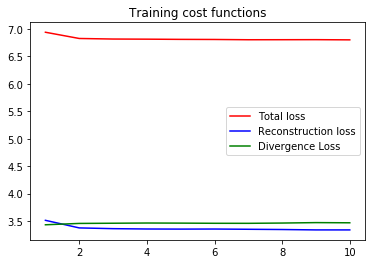

In [12]:
total_loss, recon_loss, kld_loss = zip(*training_losses)
t = range(1, epochs + 1)
plot_loss(t, total_loss, recon_loss, kld_loss)

In [13]:
# Generate samples
configs_written = 0
size = batch_size
write_header = True
config_output_path = "../data/output/"

file_name = join(config_output_path, "right_" + str(num_joints) + '_' + str(generated_sample_size) + '.csv')
print("Writing samples to: %s" % (file_name))

for i in range(math.ceil(generated_sample_size / batch_size)):
    print("Writing the %dth batch" % i)
    if generated_sample_size - configs_written < batch_size:
        size = generated_sample_size - configs_written
    samples = generate_samples(size, d_output, device, model)
    if i > 0:
        write_header = False
    write_samples_to_csv(file_name, samples, joint_limits, headers, 
                         HEADERS, write_header=write_header, print_frame=False)
    configs_written += size

with open(os.path.join(output_directory, 'model.pth'), 'wb') as f:
    torch.save(model.state_dict(), f)

Writing samples to: ../data/output/right_7_1000000.csv
Writing the 0th batch
Writing the 1th batch
Writing the 2th batch
Writing the 3th batch
Writing the 4th batch
Writing the 5th batch
Writing the 6th batch
Writing the 7th batch
Writing the 8th batch
Writing the 9th batch
Writing the 10th batch
Writing the 11th batch
Writing the 12th batch
Writing the 13th batch
Writing the 14th batch
Writing the 15th batch
Writing the 16th batch
Writing the 17th batch
Writing the 18th batch
Writing the 19th batch
Writing the 20th batch
Writing the 21th batch
Writing the 22th batch
Writing the 23th batch
Writing the 24th batch
Writing the 25th batch
Writing the 26th batch
Writing the 27th batch
Writing the 28th batch
Writing the 29th batch
Writing the 30th batch
Writing the 31th batch
Writing the 32th batch
Writing the 33th batch
Writing the 34th batch
Writing the 35th batch
Writing the 36th batch
Writing the 37th batch
Writing the 38th batch
Writing the 39th batch
Writing the 40th batch
Writing the 

Writing the 347th batch
Writing the 348th batch
Writing the 349th batch
Writing the 350th batch
Writing the 351th batch
Writing the 352th batch
Writing the 353th batch
Writing the 354th batch
Writing the 355th batch
Writing the 356th batch
Writing the 357th batch
Writing the 358th batch
Writing the 359th batch
Writing the 360th batch
Writing the 361th batch
Writing the 362th batch
Writing the 363th batch
Writing the 364th batch
Writing the 365th batch
Writing the 366th batch
Writing the 367th batch
Writing the 368th batch
Writing the 369th batch
Writing the 370th batch
Writing the 371th batch
Writing the 372th batch
Writing the 373th batch
Writing the 374th batch
Writing the 375th batch
Writing the 376th batch
Writing the 377th batch
Writing the 378th batch
Writing the 379th batch
Writing the 380th batch
Writing the 381th batch
Writing the 382th batch
Writing the 383th batch
Writing the 384th batch
Writing the 385th batch
Writing the 386th batch
Writing the 387th batch
Writing the 388t

Writing the 694th batch
Writing the 695th batch
Writing the 696th batch
Writing the 697th batch
Writing the 698th batch
Writing the 699th batch
Writing the 700th batch
Writing the 701th batch
Writing the 702th batch
Writing the 703th batch
Writing the 704th batch
Writing the 705th batch
Writing the 706th batch
Writing the 707th batch
Writing the 708th batch
Writing the 709th batch
Writing the 710th batch
Writing the 711th batch
Writing the 712th batch
Writing the 713th batch
Writing the 714th batch
Writing the 715th batch
Writing the 716th batch
Writing the 717th batch
Writing the 718th batch
Writing the 719th batch
Writing the 720th batch
Writing the 721th batch
Writing the 722th batch
Writing the 723th batch
Writing the 724th batch
Writing the 725th batch
Writing the 726th batch
Writing the 727th batch
Writing the 728th batch
Writing the 729th batch
Writing the 730th batch
Writing the 731th batch
Writing the 732th batch
Writing the 733th batch
Writing the 734th batch
Writing the 735t